# Explore here

It's recommended to use this notebook for exploration purposes.

In [6]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pandas as pd


In [7]:
pip install pandas requests beautifulsoup4  matplotlib seaborn lxml

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
url = 'https://www.mlb.com/stats/san-francisco-giants/all-time-by-season'
response = requests.get(url)
html_content = response.text

In [9]:
soup = BeautifulSoup(html_content, 'lxml')
tables = soup.find_all('table')
df = pd.read_html(str(tables))[0]

/tmp/ipykernel_667/1863342741.py:3: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(tables))[0]


In [10]:
df.columns = ['PLAYER', 'YEAR', 'TEAM', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR',
              'RBI', 'BB', 'SO', 'SB', 'CS', 'AVG', 'OBP', 'SLG', 'OPS']
# Now inspect the cleaned DataFrame
print(df.head())

                     PLAYER  YEAR TEAM    G   AB    R    H  2B  3B  HR  RBI  \
0  1BarryB BondsBondsLF1‌‌‌  2004   SF  147  373  129  135  27   3  45  101   
1  2BarryB BondsBondsLF2‌‌‌  2002   SF  143  403  117  149  31   2  46  110   
2  3BarryB BondsBondsLF3‌‌‌  2001   SF  153  476  129  156  32   2  73  137   
3  4BarryB BondsBondsLF4‌‌‌  2003   SF  130  390  111  133  22   1  45   90   
4  5BarryB BondsBondsLF5‌‌‌  1993   SF  159  539  129  181  38   4  46  123   

    BB  SO  SB  CS    AVG    OBP    SLG    OPS  
0  232  41   6   1  0.362  0.609  0.812  1.421  
1  198  47   9   2  0.370  0.582  0.799  1.381  
2  177  93  13   3  0.328  0.515  0.863  1.378  
3  148  58   7   0  0.341  0.529  0.749  1.278  
4  126  79  29  12  0.336  0.458  0.677  1.135  


In [11]:
# Convert 'YEAR' and 'R' columns to numeric, dropping rows with invalid entries
df['YEAR'] = pd.to_numeric(df['YEAR'], errors='coerce')
df['R'] = pd.to_numeric(df['R'], errors='coerce')
# Drop any rows where 'YEAR' or 'R' are NaN
df = df.dropna(subset=['YEAR', 'R'])
# Check the cleaned and numeric data
print(df[['YEAR', 'R']].head())

   YEAR    R
0  2004  129
1  2002  117
2  2001  129
3  2003  111
4  1993  129


In [14]:

# Step 3: Create SQLite database and insert data
# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('baseball_stats.db')
cur = conn.cursor()
# Create a table in the database
cur.execute('''
CREATE TABLE IF NOT EXISTS baseball_stats (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    player TEXT,
    year INTEGER,
    team TEXT,
    games INTEGER,
    at_bats INTEGER,
    runs INTEGER,
    hits INTEGER,
    doubles INTEGER,
    triples INTEGER,
    home_runs INTEGER,
    rbi INTEGER,
    walks INTEGER,
    strikeouts INTEGER,
    stolen_bases INTEGER,
    caught_stealing INTEGER,
    avg REAL,
    obp REAL,
    slg REAL,
    ops REAL
)
''')
# Commit the table creation
conn.commit()
# Insert the DataFrame values into the SQLite database
for index, row in df.iterrows():
    cur.execute('''
    INSERT INTO baseball_stats (player, year, team, games, at_bats, runs, hits, doubles, triples, home_runs,
                                rbi, walks, strikeouts, stolen_bases, caught_stealing, avg, obp, slg, ops)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''',
    (row['PLAYER'], row['YEAR'], row['TEAM'], row['G'], row['AB'], row['R'], row['H'], row['2B'],
     row['3B'], row['HR'], row['RBI'], row['BB'], row['SO'], row['SB'], row['CS'],
     row['AVG'], row['OBP'], row['SLG'], row['OPS']))
# Commit the changes to the database
conn.commit()



In [15]:
# Step 4: Verify the insert by querying the table
cur.execute('SELECT * FROM baseball_stats LIMIT 5')
rows = cur.fetchall()
for row in rows:
    print(row)

(1, '1BarryB BondsBondsLF1\u200c\u200c\u200c', 2004, 'SF', 147, 373, 129, 135, 27, 3, 45, 101, 232, 41, 6, 1, 0.362, 0.609, 0.812, 1.421)
(2, '2BarryB BondsBondsLF2\u200c\u200c\u200c', 2002, 'SF', 143, 403, 117, 149, 31, 2, 46, 110, 198, 47, 9, 2, 0.37, 0.582, 0.799, 1.381)
(3, '3BarryB BondsBondsLF3\u200c\u200c\u200c', 2001, 'SF', 153, 476, 129, 156, 32, 2, 73, 137, 177, 93, 13, 3, 0.328, 0.515, 0.863, 1.378)
(4, '4BarryB BondsBondsLF4\u200c\u200c\u200c', 2003, 'SF', 130, 390, 111, 133, 22, 1, 45, 90, 148, 58, 7, 0, 0.341, 0.529, 0.749, 1.278)
(5, '5BarryB BondsBondsLF5\u200c\u200c\u200c', 1993, 'SF', 159, 539, 129, 181, 38, 4, 46, 123, 126, 79, 29, 12, 0.336, 0.458, 0.677, 1.135)


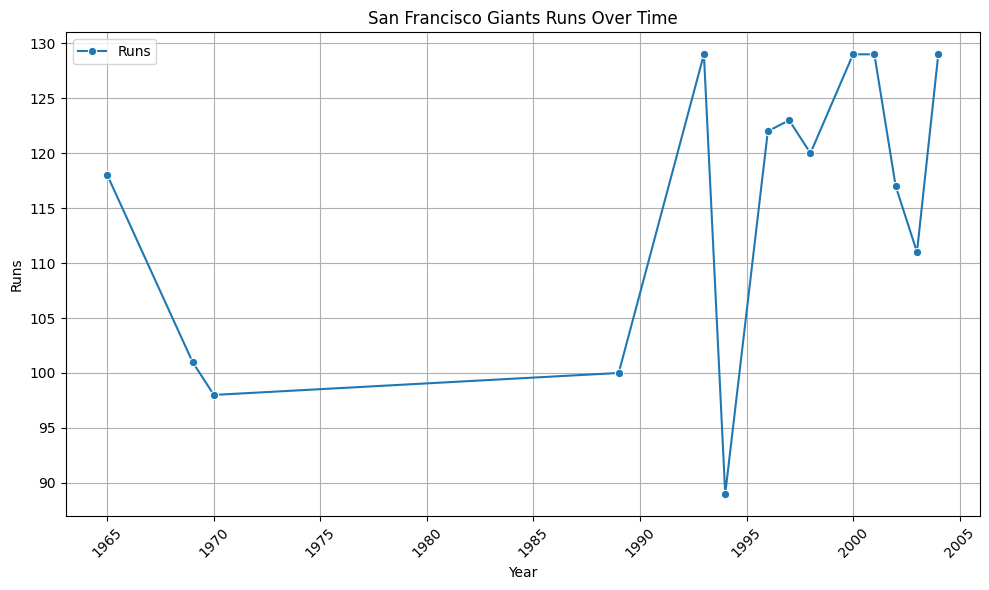

In [16]:
# Step 5: Visualize the number of runs over time by the Giants
# Query the data for visualization
cur.execute('SELECT year, runs FROM baseball_stats WHERE team="SF" ORDER BY year')
data = cur.fetchall()
# Close the connection to the database
conn.close()
# Convert the query result to a DataFrame for plotting
plot_df = pd.DataFrame(data, columns=['YEAR', 'R'])
# Plot the runs over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='YEAR', y='R', data=plot_df, marker='o', label='Runs')
# Set the labels and title
plt.xlabel('Year')
plt.ylabel('Runs')
plt.title('San Francisco Giants Runs Over Time')
# Rotate x-axis labels if necessary
plt.xticks(rotation=45)
# Display the plot
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()